In [50]:
import numpy as np
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import time
import warnings
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')  
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    Dense, Dropout, BatchNormalization, Add, Activation
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
)

from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)
from sklearn.utils.class_weight import compute_class_weight



### Import Data

In [2]:
base_dir = 'Data/ptb-diagnostic-ecg-database'
output_dir = 'Data/processed_signals'
os.makedirs(output_dir, exist_ok=True)

In [45]:
OUTPUT_DIR = 'Data/processed_signals'

In [3]:

SIGNAL_LENGTH = 5000  
NUM_LEADS = 15      

def to_key(s):
    s = s.strip('# ').lower()
    s = s.replace('(localization)','localization').replace('(at rest)','at_rest').replace('(load)','load')
    return re.sub(r'[^a-z0-9]+','_',s).strip('_')

def parse_comments(comments):
    d = {}
    for c in comments or []:
        if ':' in c:
            k, v = c.split(':', 1)
            d[to_key(k)] = v.strip()
    return d


### Stablish the categories

In [4]:
def map_primary_label(meta):
    raw = (meta.get('reason_for_admission') or meta.get('diagnose') or '').lower()
    raw = raw.replace('heartfailure','heart failure').replace('arrhythmia','dysrhythmia')
    if 'healthy control' in raw: return 'Healthy controls'
    if 'myocardial infarction' in raw: return 'Myocardial infarction'
    if 'cardiomyopathy' in raw or 'heart failure' in raw: return 'Cardiomyopathy/Heart failure'
    if 'bundle branch block' in raw: return 'Bundle branch block'
    if 'dysrhythmia' in raw: return 'Dysrhythmia'
    if 'myocardial hypertrophy' in raw: return 'Myocardial hypertrophy'
    if 'valvular heart disease' in raw: return 'Valvular heart disease'
    if 'myocarditis' in raw: return 'Myocarditis'
    return 'Other'

In [5]:
def load_ecg_safely(record_path, target_length=5000):
    try:
        record = wfdb.rdrecord(record_path)
        signal = record.p_signal
        
        if signal is None or len(signal) == 0:
            return None, None
        if signal.shape[1] != NUM_LEADS:
            
            if signal.shape[1] < NUM_LEADS:
                padding = NUM_LEADS - signal.shape[1]
                signal = np.pad(signal, ((0, 0), (0, padding)), mode='edge')
            else:
                signal = signal[:, :NUM_LEADS]
        
       
        if len(signal) >= target_length:
            signal = signal[:target_length, :]
        else:
            padding = target_length - len(signal)
            signal = np.pad(signal, ((0, padding), (0, 0)), mode='edge')
        
    
        for i in range(signal.shape[1]):
            mean = signal[:, i].mean()
            std = signal[:, i].std()
            if std > 0:
                signal[:, i] = (signal[:, i] - mean) / std
            else:
                signal[:, i] = 0  
        
     
        meta = parse_comments(record.comments)
        
        return signal, meta
    
    except Exception as e:
        return None, None

In [6]:
all_signals = []
all_labels = []
all_metadata = []

patient_folders = sorted([f for f in os.listdir(base_dir) if f.startswith('patient')])
total_files = 0
loaded_files = 0
skipped_files = 0

print(f"Found {len(patient_folders)} patient folders")

for idx, patient_folder in enumerate(patient_folders):
    patient_path = os.path.join(base_dir, patient_folder)
    
    if not os.path.isdir(patient_path):
        continue
    
    hea_files = [f for f in os.listdir(patient_path) if f.endswith('.hea')]
    total_files += len(hea_files)
    
    for hea_file in hea_files:
        record_name = hea_file.replace('.hea', '')
        record_path = os.path.join(patient_path, record_name)
        
        signal, meta = load_ecg_safely(record_path, target_length=SIGNAL_LENGTH)
        
        if signal is None:
            skipped_files += 1
            continue
        
       
        primary_label = map_primary_label(meta)
        
        if primary_label == 'Other':
            skipped_files += 1
            continue
        
       
        all_signals.append(signal)
        all_labels.append(primary_label)
        all_metadata.append(meta)
        loaded_files += 1
    
    
    if (idx + 1) % 50 == 0:
        print(f"Processed {idx + 1}/{len(patient_folders)} patients... Loaded: {loaded_files}, Skipped: {skipped_files}")



Found 290 patient folders
Processed 50/290 patients... Loaded: 162, Skipped: 0
Processed 100/290 patients... Loaded: 311, Skipped: 0
Processed 150/290 patients... Loaded: 359, Skipped: 8
Processed 200/290 patients... Loaded: 410, Skipped: 26
Processed 250/290 patients... Loaded: 467, Skipped: 32


In [7]:
print(f"Total files found: {total_files}")
print(f"Successfully loaded: {loaded_files}")
print(f"Skipped: {skipped_files}")
print(f"Success rate: {loaded_files/total_files*100:.1f}%")


Total files found: 549
Successfully loaded: 511
Skipped: 38
Success rate: 93.1%


In [8]:
X = np.array(all_signals)
y_multi = np.array(all_labels)


print(f"X shape: {X.shape}")
print(f"y shape: {y_multi.shape}")
print(f"Expected X: (511, 5000, 15)")


X shape: (511, 5000, 15)
y shape: (511,)
Expected X: (511, 5000, 15)


In [9]:

print(f"\nLabel distribution:")
unique, counts = np.unique(y_multi, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  {label}: {count} ({count/len(y_multi)*100:.1f}%)")


Label distribution:
  Bundle branch block: 17 (3.3%)
  Cardiomyopathy/Heart failure: 20 (3.9%)
  Dysrhythmia: 16 (3.1%)
  Healthy controls: 80 (15.7%)
  Myocardial infarction: 368 (72.0%)
  Myocarditis: 4 (0.8%)
  Valvular heart disease: 6 (1.2%)


### Binary Classification

In [10]:
y_binary = (y_multi == 'Myocardial infarction').astype(int)


print(f"Total samples: {len(y_binary)}")
print(f"Myocardial Infarction (MI=1): {np.sum(y_binary == 1)}")
print(f"No MI (MI=0): {np.sum(y_binary == 0)}")
print(f"MI ratio: {np.sum(y_binary == 1) / len(y_binary) * 100:.1f}%")



Total samples: 511
Myocardial Infarction (MI=1): 368
No MI (MI=0): 143
MI ratio: 72.0%


In [11]:
np.save(os.path.join(output_dir, 'X_signals_15lead.npy'), X)
np.save(os.path.join(output_dir, 'y_binary_15lead.npy'), y_binary)
np.save(os.path.join(output_dir, 'y_multi_15lead.npy'), y_multi)


### Train and Test Split


In [12]:

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y_binary,
    test_size=0.2,
    stratify=y_binary,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.2,
    stratify=y_trainval,
    random_state=42
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"  MI: {np.sum(y_train == 1)}, No-MI: {np.sum(y_train == 0)}")
print(f"  MI ratio: {np.sum(y_train == 1) / len(y_train) * 100:.1f}%")

print(f"\nValidation set: {X_val.shape[0]} samples")
print(f"  MI: {np.sum(y_val == 1)}, No-MI: {np.sum(y_val == 0)}")
print(f"  MI ratio: {np.sum(y_val == 1) / len(y_val) * 100:.1f}%")

print(f"\nTest set: {X_test.shape[0]} samples")
print(f"  MI: {np.sum(y_test == 1)}, No-MI: {np.sum(y_test == 0)}")
print(f"  MI ratio: {np.sum(y_test == 1) / len(y_test) * 100:.1f}%")


Train set: 326 samples
  MI: 235, No-MI: 91
  MI ratio: 72.1%

Validation set: 82 samples
  MI: 59, No-MI: 23
  MI ratio: 72.0%

Test set: 103 samples
  MI: 74, No-MI: 29
  MI ratio: 71.8%


### SMOTE for class imbalance

In [13]:
print(f"\nBefore SMOTE:")
print(f"  Train samples: {len(y_train)}")
print(f"  MI: {np.sum(y_train == 1)}, No-MI: {np.sum(y_train == 0)}")
print(f"  Imbalance ratio: {np.sum(y_train == 1) / np.sum(y_train == 0):.2f}:1")


X_train_flat = X_train.reshape(X_train.shape[0], -1)


smote = SMOTE(random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)


X_train_resampled = X_train_resampled.reshape(-1, 5000, 15)

print(f"\n After SMOTE:")
print(f"  Train samples: {len(y_train_resampled)}")
print(f"  MI: {np.sum(y_train_resampled == 1)}, No-MI: {np.sum(y_train_resampled == 0)}")
print(f"  Imbalance ratio: {np.sum(y_train_resampled == 1) / np.sum(y_train_resampled == 0):.2f}:1")
print(f"  Added {len(y_train_resampled) - len(y_train)} synthetic samples")


X_train = X_train_resampled
y_train = y_train_resampled


Before SMOTE:
  Train samples: 326
  MI: 235, No-MI: 91
  Imbalance ratio: 2.58:1

 After SMOTE:
  Train samples: 470
  MI: 235, No-MI: 235
  Imbalance ratio: 1.00:1
  Added 144 synthetic samples


### Data Augmentation

In [14]:
def augment_ecg_signal(signal):
    augmented = signal.copy()
    
    # 1. Add Gaussian Noise (60% chance - increased)
    if np.random.random() < 0.6:
        noise_level = np.random.uniform(0.02, 0.05)  # Variable noise
        noise = np.random.normal(0, noise_level, signal.shape)
        augmented += noise
    if np.random.random() < 0.6:
        scale_factor = np.random.uniform(0.8, 1.2)  # Wider range
        augmented *= scale_factor
    
    if np.random.random() < 0.4:
        shift = np.random.randint(-150, 150)  # Larger shifts
        augmented = np.roll(augmented, shift, axis=0)
    
    if np.random.random() < 0.4:
        time = np.arange(len(signal))
        frequency = np.random.uniform(0.001, 0.003)  # Variable frequency
        amplitude = np.random.uniform(0.05, 0.15)  # Variable amplitude
        baseline = amplitude * np.sin(2 * np.pi * frequency * time)
        augmented += baseline[:, np.newaxis]
    
    if np.random.random() < 0.25:
        num_flips = np.random.randint(1, 5)
        flip_leads = np.random.choice(signal.shape[1], size=num_flips, replace=False)
        augmented[:, flip_leads] *= -1
    
    if np.random.random() < 0.3:
        crop_size = np.random.randint(4500, 5000)
        start = np.random.randint(0, len(signal) - crop_size)
        cropped = augmented[start:start+crop_size]
   
        pad_before = np.random.randint(0, 5000 - crop_size + 1)
        pad_after = 5000 - crop_size - pad_before
        augmented = np.pad(cropped, ((pad_before, pad_after), (0, 0)), mode='edge')
    
  
    if np.random.random() < 0.3:
        time = np.arange(len(signal))
        freq = np.random.choice([50, 60])  # 50Hz or 60Hz
        amplitude = np.random.uniform(0.03, 0.08)
        interference = amplitude * np.sin(2 * np.pi * freq * time / 1000)
        augmented += interference[:, np.newaxis]
    
  
    if np.random.random() < 0.2:
        num_dropout = np.random.randint(1, 3)
        dropout_leads = np.random.choice(signal.shape[1], size=num_dropout, replace=False)
        augmented[:, dropout_leads] = 0
    
    
    if np.random.random() < 0.25:
        warp_factor = np.random.uniform(0.95, 1.05)
        indices = np.arange(len(signal))
        warped_indices = (indices * warp_factor).astype(int)
        warped_indices = np.clip(warped_indices, 0, len(signal) - 1)
        augmented = augmented[warped_indices]
    
    return augmented



In [15]:
# Test augmentation
test_signal = X_train[0]
test_augmented = augment_ecg_signal(test_signal)
print(f"\nAugmentation test:")
print(f"  Original shape: {test_signal.shape}")
print(f"  Augmented shape: {test_augmented.shape}")
print(f"  Signals different: {not np.allclose(test_signal, test_augmented)}")


Augmentation test:
  Original shape: (5000, 15)
  Augmented shape: (5000, 15)
  Signals different: True


### Data Generator

In [16]:
import tensorflow as tf

class ECGDataGenerator(tf.keras.utils.Sequence):

    def __init__(self, X, y, batch_size=32, shuffle=True, augment=False, mixup_alpha=0.2):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.mixup_alpha = mixup_alpha
        self.indices = np.arange(len(self.X))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        
        X_batch = self.X[batch_indices].copy()
        y_batch = self.y[batch_indices].copy()
        
        # Apply augmentation
        if self.augment:
            X_batch = np.array([augment_ecg_signal(x) for x in X_batch])
            
            # Apply mixup (30% chance)
            if np.random.random() < 0.3 and len(X_batch) > 1:
                lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
                shuffle_indices = np.random.permutation(len(X_batch))
                X_batch = lam * X_batch + (1 - lam) * X_batch[shuffle_indices]
                y_batch = lam * y_batch + (1 - lam) * y_batch[shuffle_indices]
        
        return X_batch, y_batch
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)



### Create generators

In [17]:


train_gen = ECGDataGenerator(
    X_train, y_train,
    batch_size=32,
    shuffle=True,
    augment=True,
    mixup_alpha=0.2
)

val_gen = ECGDataGenerator(
    X_val, y_val,
    batch_size=32,
    shuffle=False,
    augment=False
)

test_gen = ECGDataGenerator(
    X_test, y_test,
    batch_size=32,
    shuffle=False,
    augment=False
)


### Use of Focal Loss

In [18]:
def focal_loss(gamma=2.0, alpha=0.75):
   
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        y_true = tf.cast(y_true, tf.float32)
        
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_weight = alpha_t * tf.pow((1 - p_t), gamma)
        
        loss = -focal_weight * tf.math.log(p_t)
        return tf.reduce_mean(loss)
    
    return focal_loss_fixed


### Resnet Arquitecture

In [19]:


def residual_block(x, filters, kernel_size=3, dropout_rate=0.3):
  
    shortcut = x
    
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    
   
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)
    
  
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x



In [20]:
def create_resnet_ecg_model(input_shape, num_classes=1):
    inputs = Input(shape=input_shape)
    
   
    x = Conv1D(64, 7, padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.3)(x)
    
   
    x = residual_block(x, 64, kernel_size=5, dropout_rate=0.3)
    x = MaxPooling1D(3)(x)
    
 
    x = residual_block(x, 128, kernel_size=5, dropout_rate=0.3)
    x = residual_block(x, 128, kernel_size=5, dropout_rate=0.3)
    x = MaxPooling1D(3)(x)
    
   
    x = residual_block(x, 256, kernel_size=3, dropout_rate=0.4)
    x = residual_block(x, 256, kernel_size=3, dropout_rate=0.4)
    x = MaxPooling1D(3)(x)
    

    x = residual_block(x, 512, kernel_size=3, dropout_rate=0.4)
    
   
    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model



## Training Model

In [21]:
os.makedirs('models', exist_ok=True)


input_shape = (X_train.shape[1], X_train.shape[2])  # (5000, 15)
model = create_resnet_ecg_model(input_shape)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.75),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)


print(f"Input shape: {input_shape}")
model.summary()




Input shape: (5000, 15)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5000, 15)]           0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 5000, 64)             6784      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 5000, 64)             256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 5000, 64)             0         

In [22]:
def lr_schedule(epoch, lr):
    if epoch < 5:  # Warmup for 5 epochs
        return 0.0001 * (epoch + 1)
    elif epoch < 30:
        return 0.001
    elif epoch < 60:
        return 0.0005
    else:
        return 0.0001

In [23]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'models/best_resnet_ecg_improved.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        verbose=1
    ),
    LearningRateScheduler(lr_schedule, verbose=1)
]


In [25]:

start_time = time.time()

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

end_time = time.time()
training_time = (end_time - start_time) / 60


print(f"Training time: {training_time:.2f} minutes")
print(f"Total epochs: {len(history.history['loss'])}")
print(f"Best val_accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Best val_loss: {min(history.history['val_loss']):.4f}")


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100


15/15 [==============================] - ETA: 0s - loss: 3.0793 - accuracy: 0.4809 - precision: 0.4299 - recall: 0.6750 - auc: 0.4890
Epoch 1: val_accuracy improved from -inf to 0.71951, saving model to models\best_resnet_ecg_improved.keras
15/15 [==============================] - 29s 1s/step - loss: 3.0793 - accuracy: 0.4809 - precision: 0.4299 - recall: 0.6750 - auc: 0.4890 - val_loss: 2.9521 - val_accuracy: 0.7195 - val_precision: 0.7195 - val_recall: 1.0000 - val_auc: 0.7100 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0002.
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 2.9082 - accuracy: 0.5319 - precision: 0.4904 - recall: 0.8357 - auc: 0.6367
Epoch 2: val_accuracy did not improve from 0.71951
15/15 [==============================] - 12s 815ms/step - loss: 2.9082 - accuracy: 0.5319 - precision: 0.4904 - recall: 0.8357 - auc: 0.6367 - val_loss: 2.836

## Evaluation of Model

In [26]:

best_model = tf.keras.models.load_model(
    'models/best_resnet_ecg_improved.keras',
    custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.75)}
)

In [27]:
y_pred_probs = best_model.predict(test_gen, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

4/4 [==============================] - 2s 215ms/step


In [28]:

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_pred_probs)


cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = recall


print(f"  Accuracy:      {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision:     {precision:.4f}")
print(f"  Recall:        {recall:.4f}")
print(f"  F1-Score:      {f1:.4f}")
print(f"  AUC-ROC:       {auc:.4f}")
print(f"  Sensitivity:   {sensitivity:.4f} (TPR)")
print(f"  Specificity:   {specificity:.4f} (TNR)")



  Accuracy:      0.8447 (84.47%)
  Precision:     0.8372
  Recall:        0.9730
  F1-Score:      0.9000
  AUC-ROC:       0.9091
  Sensitivity:   0.9730 (TPR)
  Specificity:   0.5172 (TNR)


In [29]:
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No-MI', 'MI'], digits=4))

print("\n Confusion Matrix:")
print(f"                Predicted")
print(f"              No-MI    MI")
print(f"Actual No-MI   [{tn:3d}]  [{fp:3d}]")
print(f"Actual MI      [{fn:3d}]  [{tp:3d}]")




 Classification Report:
              precision    recall  f1-score   support

       No-MI     0.8824    0.5172    0.6522        29
          MI     0.8372    0.9730    0.9000        74

    accuracy                         0.8447       103
   macro avg     0.8598    0.7451    0.7761       103
weighted avg     0.8499    0.8447    0.8302       103


 Confusion Matrix:
                Predicted
              No-MI    MI
Actual No-MI   [ 15]  [ 14]
Actual MI      [  2]  [ 72]


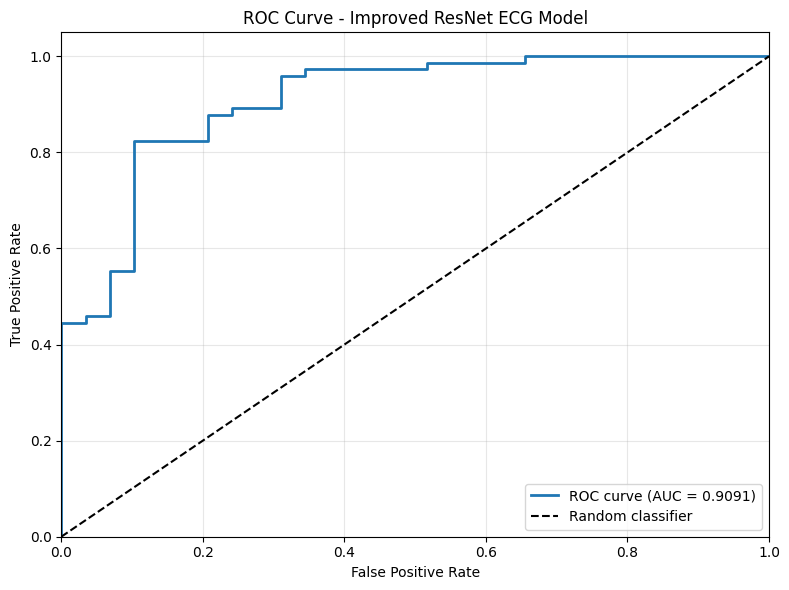

In [30]:

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Improved ResNet ECG Model')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('models/roc_curve_single_model.png', dpi=300)
plt.show()

## SECOND MODEL


### ENSEMBLE LEARNING(5 MODELS)


Training multiple models with different random seeds and averaging their predictions often gives 1-3% additional improvement.

In [40]:
MODEL_DIR = 'models/cross_validation'
os.makedirs(MODEL_DIR, exist_ok=True)

In [32]:

N_SPLITS = 5  
RANDOM_STATE = 42

In [33]:
BATCH_SIZE = 32
EPOCHS = 100
INITIAL_LR = 0.001


In [34]:
def augment_ecg_signal(signal):
    augmented = signal.copy()
    
    if np.random.random() < 0.6:
        noise_level = np.random.uniform(0.02, 0.05)
        noise = np.random.normal(0, noise_level, signal.shape)
        augmented += noise
    
    if np.random.random() < 0.6:
        scale_factor = np.random.uniform(0.8, 1.2)
        augmented *= scale_factor

    if np.random.random() < 0.4:
        shift = np.random.randint(-150, 150)
        augmented = np.roll(augmented, shift, axis=0)
    
    if np.random.random() < 0.4:
        time = np.arange(len(signal))
        frequency = np.random.uniform(0.001, 0.003)
        amplitude = np.random.uniform(0.05, 0.15)
        baseline = amplitude * np.sin(2 * np.pi * frequency * time)
        augmented += baseline[:, np.newaxis]
    
    return augmented



In [35]:
class ECGDataGenerator(tf.keras.utils.Sequence):

    def __init__(self, X, y, batch_size=32, shuffle=True, augment=False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.X))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = self.X[batch_indices]
        y_batch = self.y[batch_indices]
        
        if self.augment:
            X_batch = np.array([augment_ecg_signal(x) for x in X_batch])
        
        return X_batch, y_batch
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)




In [36]:
def residual_block(x, filters, kernel_size=3, dropout_rate=0.3):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

In [37]:

def create_resnet_ecg_model(input_shape, num_classes=1):

    inputs = Input(shape=input_shape)
    
    x = Conv1D(64, 7, padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.3)(x)
    
   
    x = residual_block(x, 64, kernel_size=5, dropout_rate=0.3)
    x = MaxPooling1D(3)(x)
    
   
    x = residual_block(x, 128, kernel_size=5, dropout_rate=0.3)
    x = residual_block(x, 128, kernel_size=5, dropout_rate=0.3)
    x = MaxPooling1D(3)(x)
    

    x = residual_block(x, 256, kernel_size=3, dropout_rate=0.4)
    x = residual_block(x, 256, kernel_size=3, dropout_rate=0.4)
    x = MaxPooling1D(3)(x)
    

    x = residual_block(x, 512, kernel_size=3, dropout_rate=0.4)

    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model

## FOCAL LOSS

In [38]:

def focal_loss(gamma=2.0, alpha=0.75):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        y_true = tf.cast(y_true, tf.float32)
        
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        focal_weight = tf.pow(1 - pt, gamma)
        
        ce = -tf.math.log(pt)
        loss = alpha * focal_weight * ce
        
        return tf.reduce_mean(loss)
    
    return focal_loss_fixed

In [39]:
def lr_schedule(epoch, lr):

    if epoch < 5: 
        return 0.0001 * (epoch + 1)
    elif epoch < 30:
        return 0.001
    elif epoch < 60:
        return 0.0005
    else:
        return 0.0001


### K-FOLD CROSS VALIDATION

In [ ]:

def train_with_kfold_cv(X, y, n_splits=5, test_size=0.2):
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=RANDOM_STATE
    )
    
    print(f"Train+Val set: {len(X_trainval)} samples")
    print(f"  MI: {np.sum(y_trainval == 1)}, No-MI: {np.sum(y_trainval == 0)}")
    print(f"Final test set: {len(X_test)} samples")
    print(f"  MI: {np.sum(y_test == 1)}, No-MI: {np.sum(y_test == 0)}")
    print()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    
    fold_results = {
        'models': [],
        'histories': [],
        'val_metrics': [],
        'train_metrics': []
    }
    

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
        print("\n" + "=" * 80)
        print(f"FOLD {fold + 1}/{n_splits}")
        print("=" * 80)
      
        X_train_fold = X_trainval[train_idx]
        y_train_fold = y_trainval[train_idx]
        X_val_fold = X_trainval[val_idx]
        y_val_fold = y_trainval[val_idx]
        
        print(f"Training set: {len(X_train_fold)} samples")
        print(f"  MI: {np.sum(y_train_fold == 1)}, No-MI: {np.sum(y_train_fold == 0)}")
        print(f"Validation set: {len(X_val_fold)} samples")
        print(f"  MI: {np.sum(y_val_fold == 1)}, No-MI: {np.sum(y_val_fold == 0)}")
        
    
        print("\nApplying SMOTE to training data...")
        X_train_flat = X_train_fold.reshape(X_train_fold.shape[0], -1)
        smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=3)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train_fold)
        X_train_resampled = X_train_resampled.reshape(-1, X.shape[1], X.shape[2])
        
        print(f"After SMOTE: {len(y_train_resampled)} samples")
        print(f"  MI: {np.sum(y_train_resampled == 1)}, No-MI: {np.sum(y_train_resampled == 0)}")
        
  
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(y_train_resampled),
            y=y_train_resampled
        )
        class_weight_dict = dict(enumerate(class_weights))
        print(f"Class weights: {class_weight_dict}")

        train_generator = ECGDataGenerator(
            X_train_resampled, y_train_resampled,
            batch_size=BATCH_SIZE,
            shuffle=True,
            augment=True
        )
        
        val_generator = ECGDataGenerator(
            X_val_fold, y_val_fold,
            batch_size=BATCH_SIZE,
            shuffle=False,
            augment=False
        )
        
  
        input_shape = (X.shape[1], X.shape[2])
        model = create_resnet_ecg_model(input_shape)
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
            loss=focal_loss(gamma=2.0, alpha=0.75),
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')
            ]
        )
        
    
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=20,
                restore_best_weights=True,
                verbose=1
            ),
            ModelCheckpoint(
                os.path.join(MODEL_DIR, f'best_model_fold_{fold+1}.keras'),
                monitor='val_auc',
                save_best_only=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=8,
                min_lr=1e-6,
                verbose=1
            ),
            LearningRateScheduler(lr_schedule, verbose=0)
        ]
        

        print(f"\nTraining model for fold {fold + 1}...")
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=EPOCHS,
            callbacks=callbacks,
            class_weight=class_weight_dict,
            verbose=1
        )
        
      
        print(f"\nEvaluating fold {fold + 1} on validation set...")
        y_val_pred_probs = model.predict(X_val_fold, verbose=0)
        y_val_pred = (y_val_pred_probs > 0.5).astype(int).flatten()
        
        val_metrics = {
            'accuracy': accuracy_score(y_val_fold, y_val_pred),
            'precision': precision_score(y_val_fold, y_val_pred),
            'recall': recall_score(y_val_fold, y_val_pred),
            'f1': f1_score(y_val_fold, y_val_pred),
            'auc': roc_auc_score(y_val_fold, y_val_pred_probs)
        }
        

        cm = confusion_matrix(y_val_fold, y_val_pred)
        tn, fp, fn, tp = cm.ravel()
        val_metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        print(f"\nFold {fold + 1} Validation Results:")
        print(f"  Accuracy:    {val_metrics['accuracy']:.4f}")
        print(f"  Precision:   {val_metrics['precision']:.4f}")
        print(f"  Recall:      {val_metrics['recall']:.4f}")
        print(f"  Specificity: {val_metrics['specificity']:.4f}")
        print(f"  F1-Score:    {val_metrics['f1']:.4f}")
        print(f"  AUC:         {val_metrics['auc']:.4f}")
        print(f"\nConfusion Matrix:")
        print(cm)
        
        fold_results['models'].append(model)
        fold_results['histories'].append(history.history)
        fold_results['val_metrics'].append(val_metrics)
    avg_metrics = {}
    for metric in fold_results['val_metrics'][0].keys():
        values = [fold[metric] for fold in fold_results['val_metrics']]
        avg_metrics[metric] = {
            'mean': np.mean(values),
            'std': np.std(values),
            'values': values
        }
    
    print("\nAverage Metrics Across All Folds:")
    print("-" * 80)
    for metric, stats in avg_metrics.items():
        print(f"{metric.capitalize():12s}: {stats['mean']:.4f} ± {stats['std']:.4f}")
    print("\nAverage Metrics Across All Folds:")
    for metric, stats in avg_metrics.items():
        print(f"{metric.capitalize():12s}: {stats['mean']:.4f} ± {stats['std']:.4f}")
        print("Making ensemble predictions...")
    test_predictions = []
    for i, model in enumerate(fold_results['models']):
        pred = model.predict(X_test, verbose=0)
        test_predictions.append(pred)
        print(f"  Model {i+1} completed")
    

    y_test_pred_probs_ensemble = np.mean(test_predictions, axis=0).flatten()
    y_test_pred_ensemble = (y_test_pred_probs_ensemble > 0.5).astype(int)
    
 
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred_ensemble),
        'precision': precision_score(y_test, y_test_pred_ensemble),
        'recall': recall_score(y_test, y_test_pred_ensemble),
        'f1': f1_score(y_test, y_test_pred_ensemble),
        'auc': roc_auc_score(y_test, y_test_pred_probs_ensemble)
    }
    
    cm_test = confusion_matrix(y_test, y_test_pred_ensemble)
    tn, fp, fn, tp = cm_test.ravel()
    test_metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print("\nEnsemble Test Set Results:")
    print("-" * 80)
    print(f"Accuracy:    {test_metrics['accuracy']:.4f}")
    print(f"Precision:   {test_metrics['precision']:.4f}")
    print(f"Recall:      {test_metrics['recall']:.4f}")
    print(f"Specificity: {test_metrics['specificity']:.4f}")
    print(f"F1-Score:    {test_metrics['f1']:.4f}")
    print(f"AUC:         {test_metrics['auc']:.4f}")
    print(f"\nConfusion Matrix:")
    print(cm_test)
    print(f"\nTrue Negatives:  {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives:  {tp}")
    
 
    fold_results['test_data'] = {
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_test_pred_ensemble,
        'y_pred_probs': y_test_pred_probs_ensemble,
        'metrics': test_metrics,
        'confusion_matrix': cm_test
    }
    
    fold_results['cv_summary'] = avg_metrics
    
    return fold_results
    

In [43]:
def plot_cv_results(fold_results, save_dir=MODEL_DIR):
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    metrics = ['accuracy', 'precision', 'recall', 'specificity', 'f1', 'auc']
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 3, idx % 3]
        values = fold_results['cv_summary'][metric]['values']
        mean_val = fold_results['cv_summary'][metric]['mean']
        std_val = fold_results['cv_summary'][metric]['std']
        
        folds = np.arange(1, len(values) + 1)
        ax.bar(folds, values, alpha=0.7, color='steelblue')
        ax.axhline(y=mean_val, color='red', linestyle='--', 
                   label=f'Mean: {mean_val:.4f} ± {std_val:.4f}')
        
        ax.set_xlabel('Fold')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'{metric.capitalize()} Across Folds')
        ax.legend()
        ax.set_xticks(folds)
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'cv_metrics_across_folds.png'), dpi=300)
    plt.show()
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    for fold_idx, history in enumerate(fold_results['histories']):
        # Loss
        axes[0, 0].plot(history['loss'], alpha=0.6, label=f'Fold {fold_idx+1}')
        axes[0, 1].plot(history['val_loss'], alpha=0.6, label=f'Fold {fold_idx+1}')
        
    
        axes[1, 0].plot(history['accuracy'], alpha=0.6, label=f'Fold {fold_idx+1}')
        axes[1, 1].plot(history['val_accuracy'], alpha=0.6, label=f'Fold {fold_idx+1}')
    
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    axes[0, 1].set_title('Validation Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    axes[1, 0].set_title('Training Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    axes[1, 1].set_title('Validation Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'cv_training_history.png'), dpi=300)
    plt.show()
    
    # 3. Plot ROC curve for test set
    fig, ax = plt.subplots(figsize=(8, 6))
    
    test_data = fold_results['test_data']
    fpr, tpr, _ = roc_curve(test_data['y_test'], test_data['y_pred_probs'])
    auc_score = test_data['metrics']['auc']
    
    ax.plot(fpr, tpr, label=f'Ensemble (AUC = {auc_score:.4f})', linewidth=2)
    ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve - Ensemble Model on Test Set')
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'roc_curve_ensemble.png'), dpi=300)
    plt.show()
    
    # 4. Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cm = test_data['confusion_matrix']
    
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['No MI', 'MI'],
           yticklabels=['No MI', 'MI'],
           title='Confusion Matrix - Ensemble on Test Set',
           ylabel='True label',
           xlabel='Predicted label')
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black",
                   fontsize=20)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'confusion_matrix_ensemble.png'), dpi=300)
    plt.show()

In [44]:
def save_cv_results_to_csv(fold_results, save_dir=MODEL_DIR):
    fold_df = pd.DataFrame(fold_results['val_metrics'])
    fold_df.index = [f'Fold_{i+1}' for i in range(len(fold_df))]
    fold_df.to_csv(os.path.join(save_dir, 'cv_fold_metrics.csv'))
    
    summary_data = []
    for metric, stats in fold_results['cv_summary'].items():
        summary_data.append({
            'Metric': metric,
            'Mean': stats['mean'],
            'Std': stats['std']
        })
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(os.path.join(save_dir, 'cv_summary_stats.csv'), index=False)
    
 
    test_metrics_df = pd.DataFrame([fold_results['test_data']['metrics']])
    test_metrics_df.to_csv(os.path.join(save_dir, 'test_set_metrics.csv'), index=False)
    
    print(f"\nResults saved to {save_dir}")


Loading preprocessed data...
Data loaded successfully!
  X shape: (511, 5000, 15)
  y shape: (511,)
  MI samples: 368
  No-MI samples: 143

Starting 5-Fold Cross-Validation...
Train+Val set: 408 samples
  MI: 294, No-MI: 114
Final test set: 103 samples
  MI: 74, No-MI: 29


FOLD 1/5
Training set: 326 samples
  MI: 235, No-MI: 91
Validation set: 82 samples
  MI: 59, No-MI: 23

Applying SMOTE to training data...
After SMOTE: 470 samples
  MI: 235, No-MI: 235
Class weights: {0: 1.0, 1: 1.0}

Training model for fold 1...
Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 3.4255 - accuracy: 0.5362 - precision: 0.5388 - recall: 0.5021 - auc: 0.5500
Epoch 1: val_auc improved from inf to 0.56890, saving model to models/cross_validation\best_model_fold_1.keras
15/15 [==============================] - 25s 934ms/step - loss: 3.4255 - accuracy: 0.5362 - precision: 0.5388 - recall: 0.5021 - auc: 0.5500 - val_loss: 3.0122 - val_accuracy: 0.7195 - val_precision: 0.7195 - val_recall

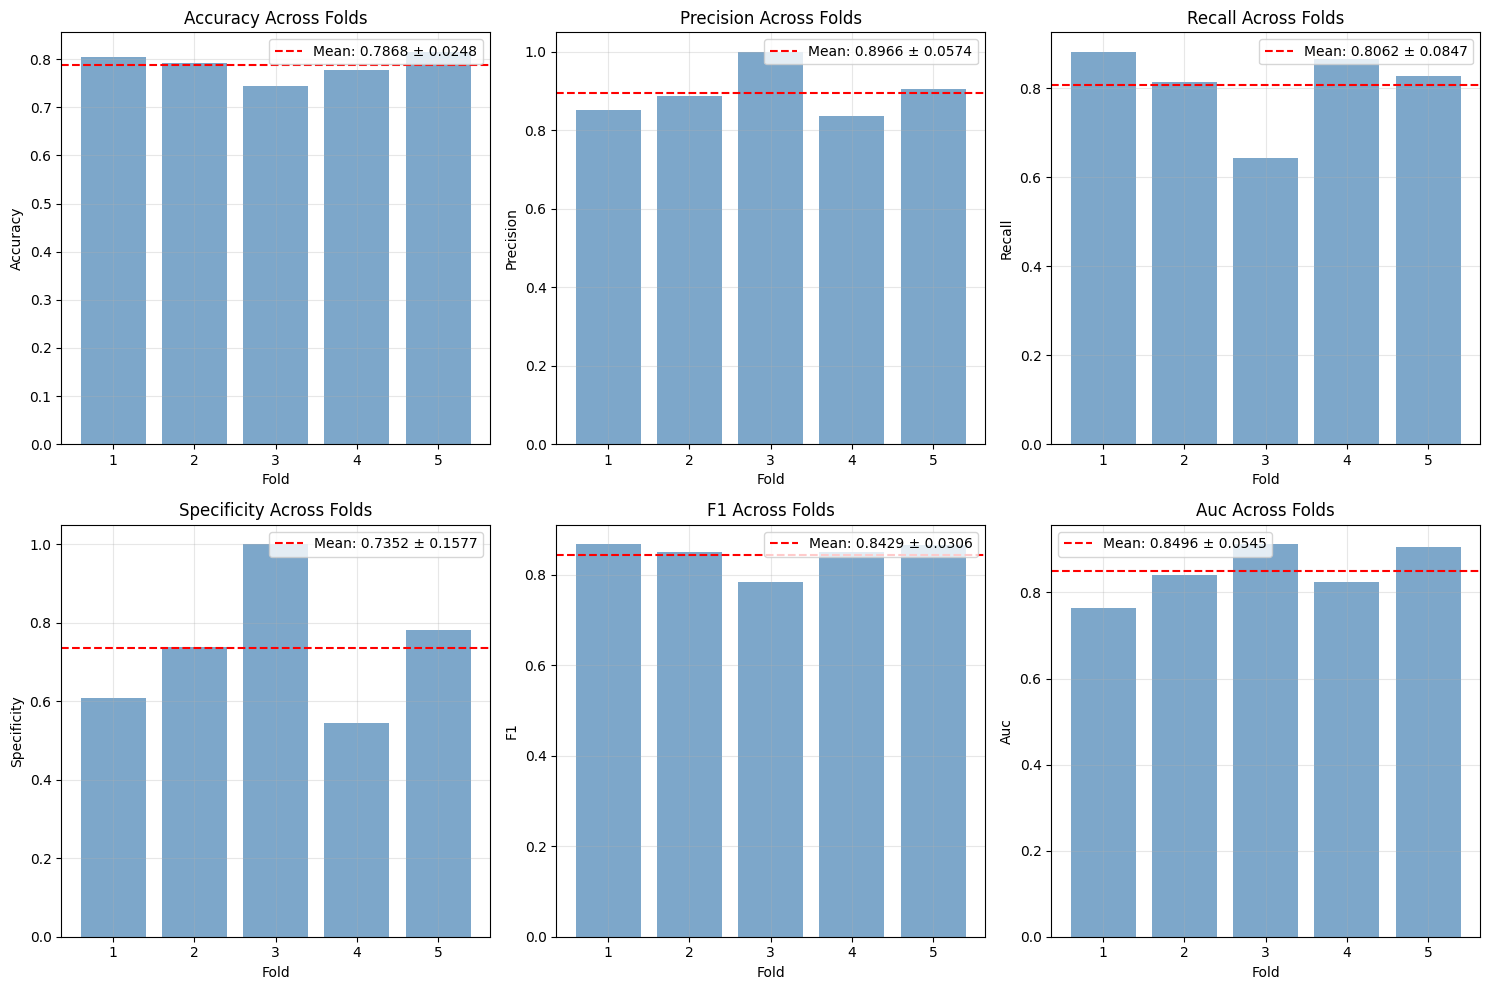

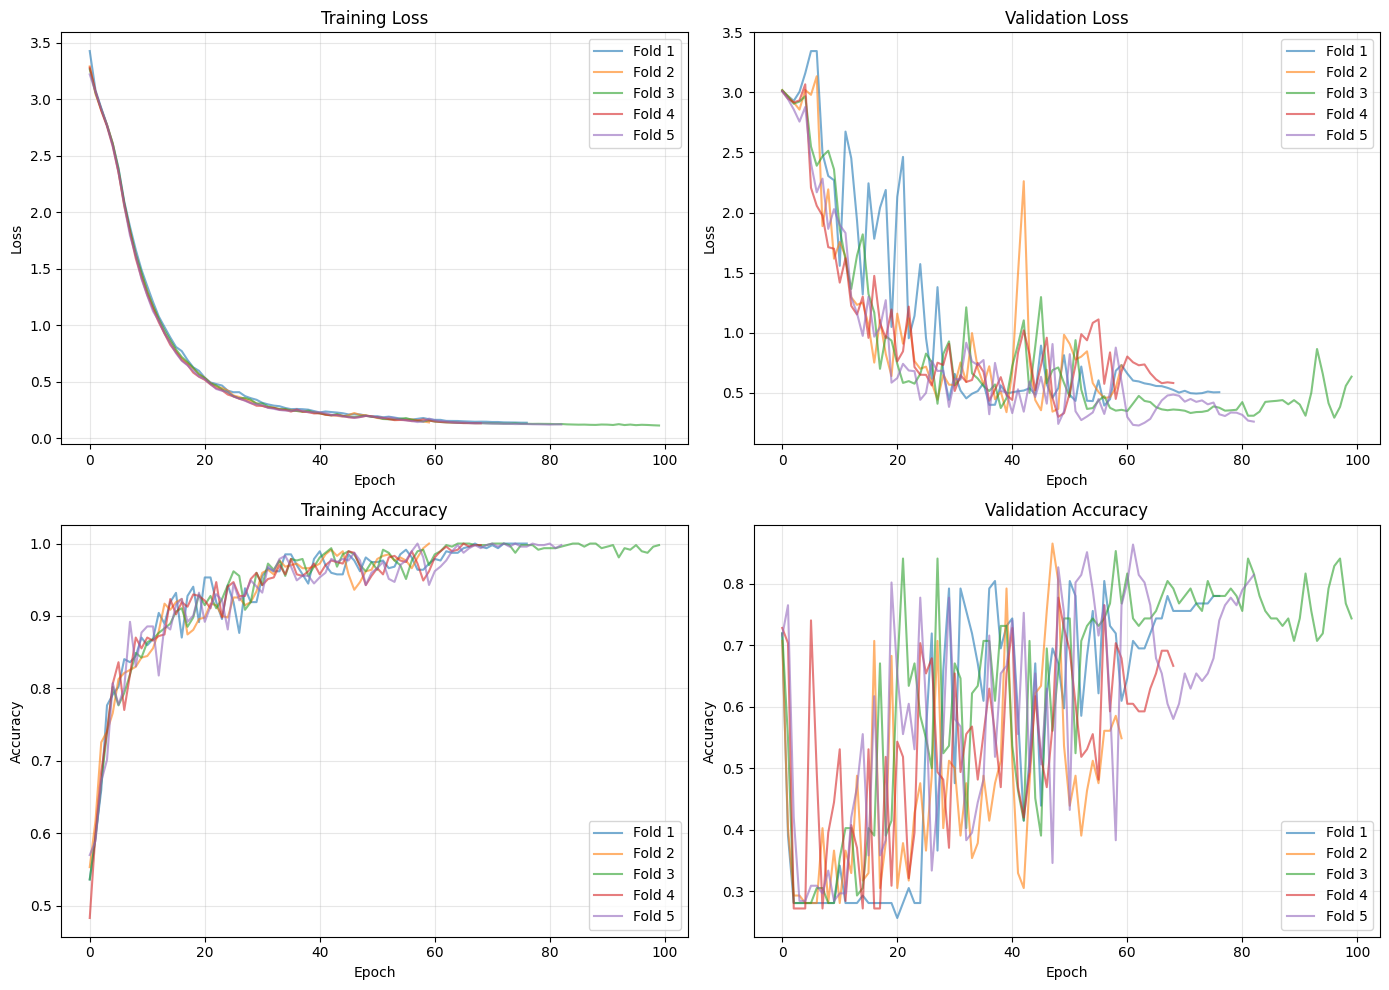

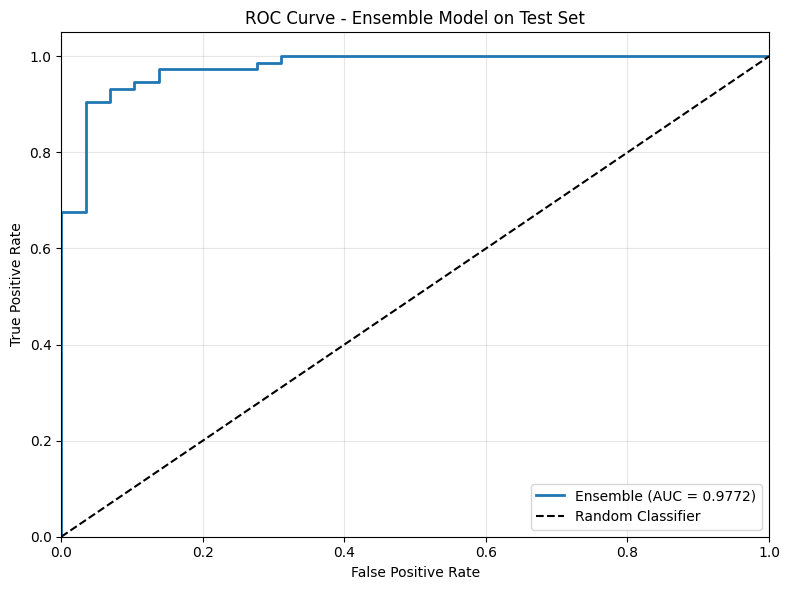

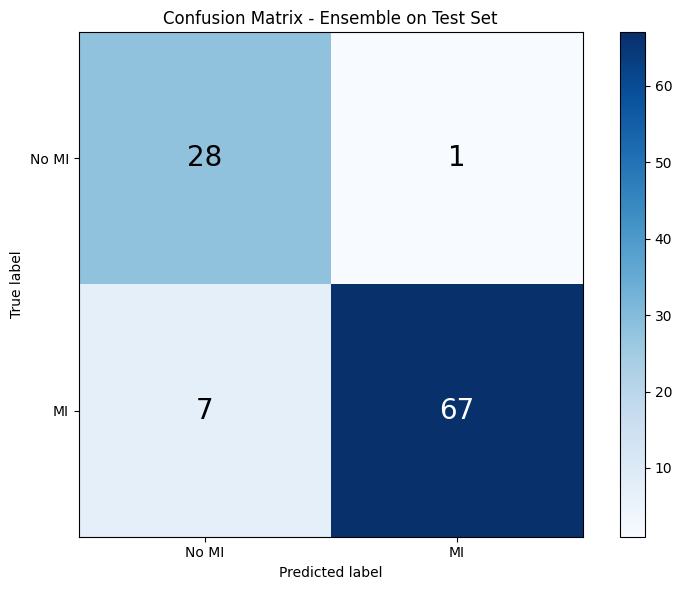


Saving results to CSV...

Results saved to models/cross_validation

Models saved to: models/cross_validation
Total folds trained: 5

Final Ensemble Performance on Test Set:
  Accuracy:  0.9223
  AUC:       0.9772
  F1-Score:  0.9437


In [ ]:
def main():

    
    print("\nLoading preprocessed data...")
    X = np.load(os.path.join(OUTPUT_DIR, 'X_signals_15lead.npy'))
    y = np.load(os.path.join(OUTPUT_DIR, 'y_binary_15lead.npy'))
    
    print(f"Data loaded successfully!")
    print(f"  X shape: {X.shape}")
    print(f"  y shape: {y.shape}")
    print(f"  MI samples: {np.sum(y == 1)}")
    print(f"  No-MI samples: {np.sum(y == 0)}")
    

    print(f"\nStarting {N_SPLITS}-Fold Cross-Validation...")
    fold_results = train_with_kfold_cv(X, y, n_splits=N_SPLITS, test_size=0.2)
    

    plot_cv_results(fold_results)
    

    print("\nSaving results to CSV...")
    save_cv_results_to_csv(fold_results)
    
    print(f"\nModels saved to: {MODEL_DIR}")
    print(f"Total folds trained: {N_SPLITS}")
    print(f"\nFinal Ensemble Performance on Test Set:")
    print(f"  Accuracy:  {fold_results['test_data']['metrics']['accuracy']:.4f}")
    print(f"  AUC:       {fold_results['test_data']['metrics']['auc']:.4f}")
    print(f"  F1-Score:  {fold_results['test_data']['metrics']['f1']:.4f}")
    
    return fold_results



Loading preprocessed data...
Data loaded successfully!
  X shape: (511, 5000, 15)
  y shape: (511,)
  MI samples: 368
  No-MI samples: 143

Starting 5-Fold Cross-Validation...
Train+Val set: 408 samples
  MI: 294, No-MI: 114
Final test set: 103 samples
  MI: 74, No-MI: 29


FOLD 1/5
Training set: 326 samples
  MI: 235, No-MI: 91
Validation set: 82 samples
  MI: 59, No-MI: 23

Applying SMOTE to training data...
After SMOTE: 470 samples
  MI: 235, No-MI: 235
Class weights: {0: 1.0, 1: 1.0}

Training model for fold 1...
Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 3.2742 - accuracy: 0.5894 - precision: 0.5890 - recall: 0.5915 - auc: 0.5807
Epoch 1: val_auc improved from inf to 0.64996, saving model to models/cross_validation\best_model_fold_1.keras
15/15 [==============================] - 13s 507ms/step - loss: 3.2742 - accuracy: 0.5894 - precision: 0.5890 - recall: 0.5915 - auc: 0.5807 - val_loss: 3.0090 - val_accuracy: 0.7195 - val_precision: 0.7195 - val_recall

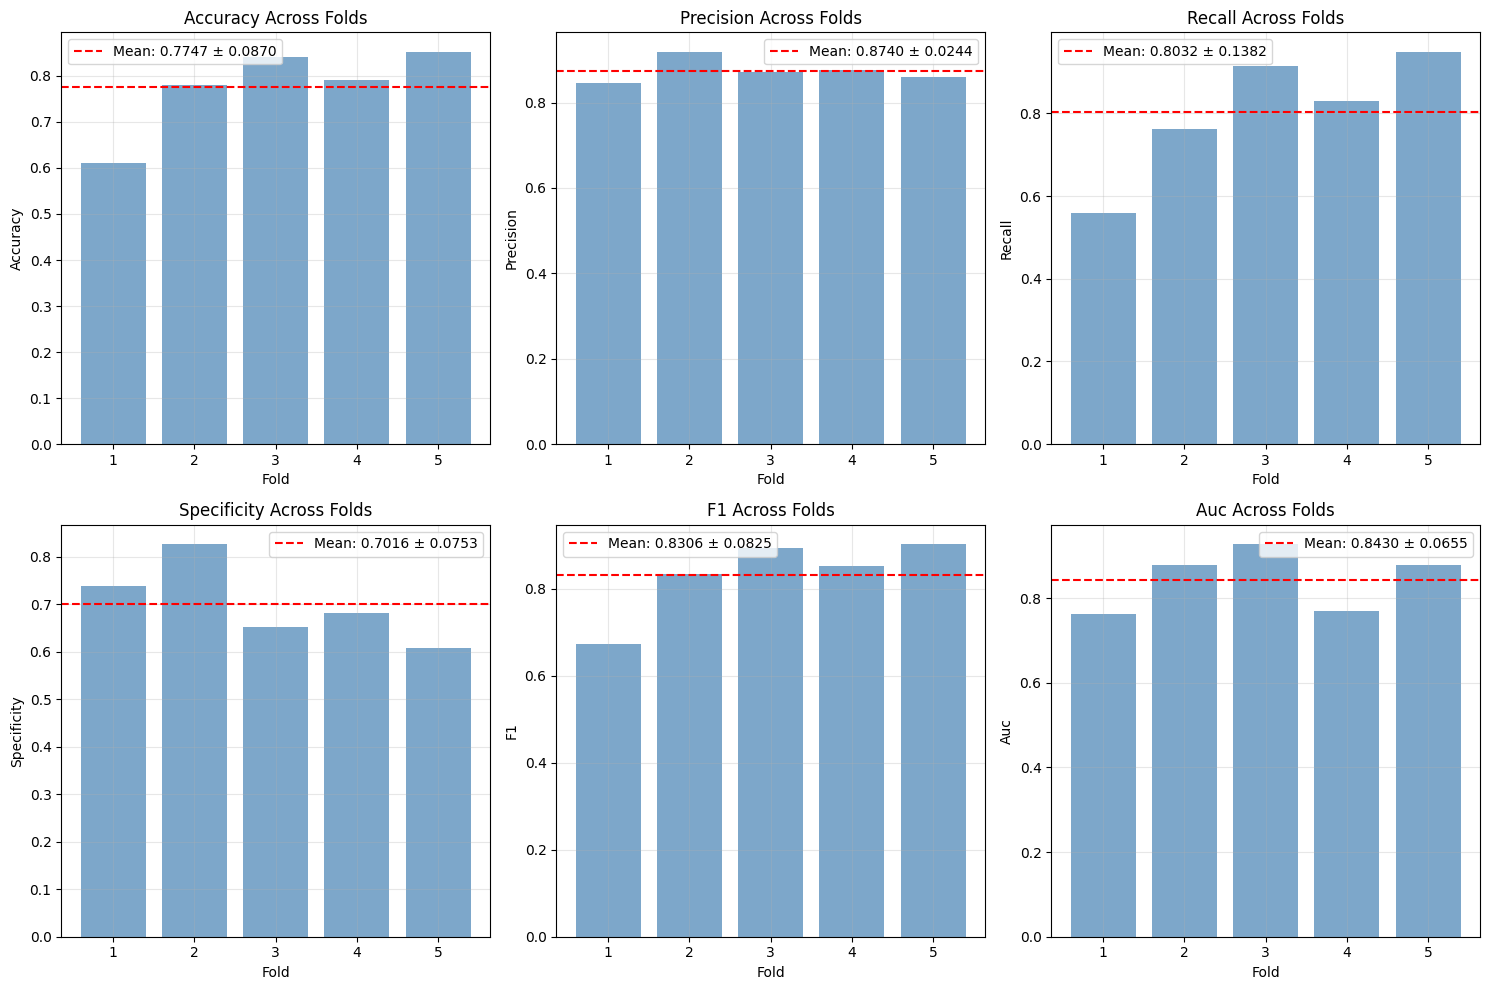

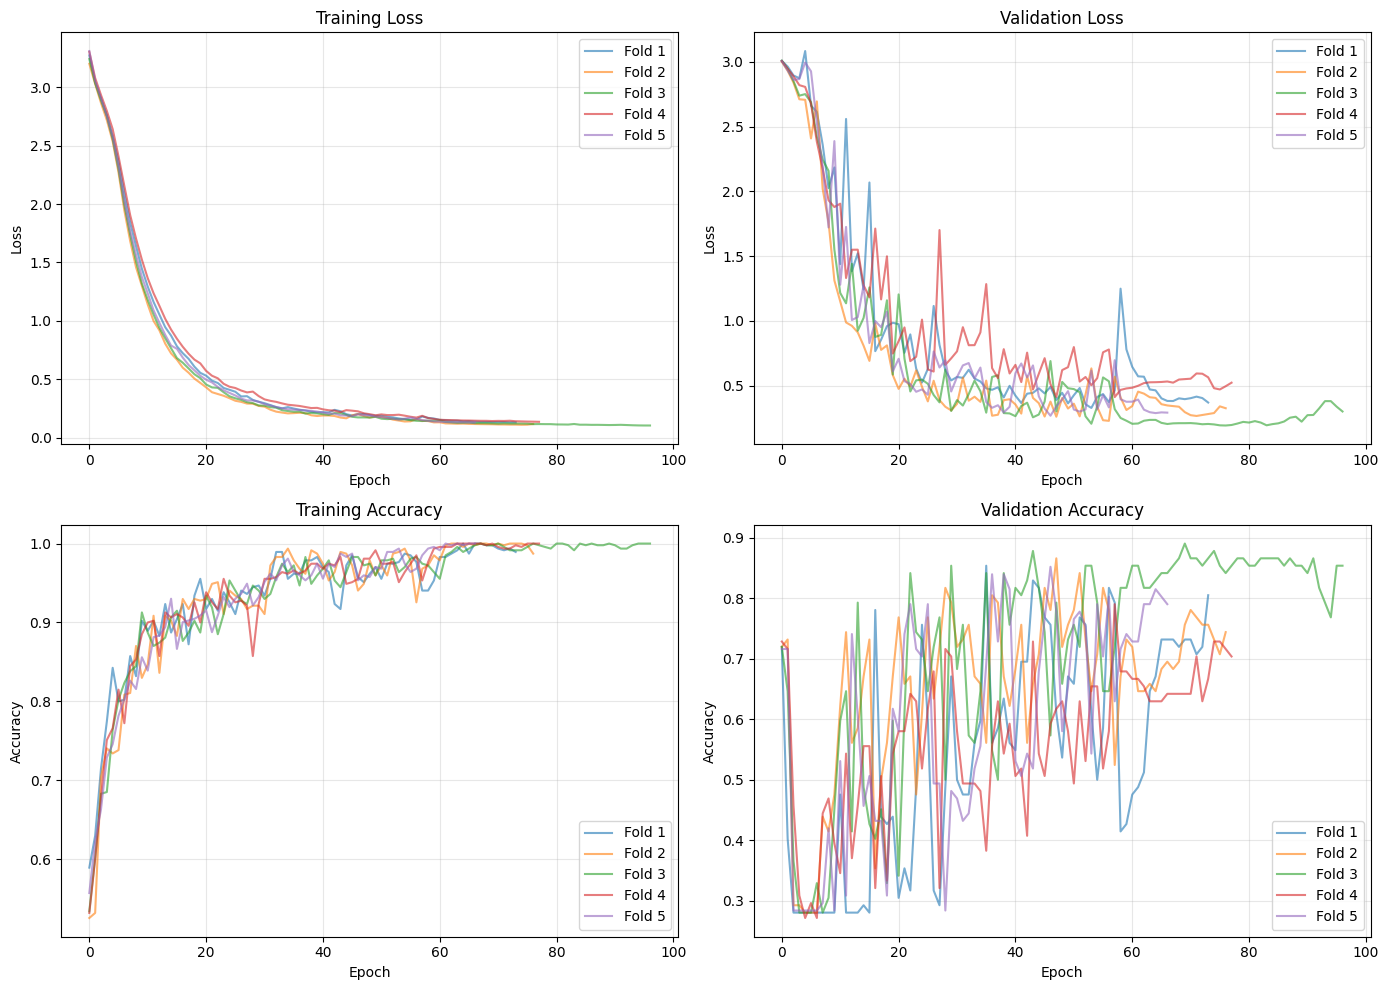

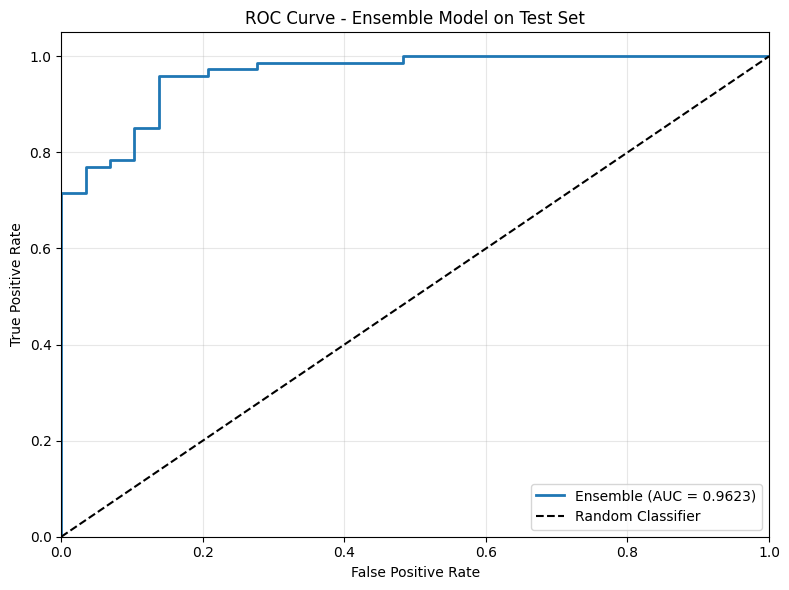

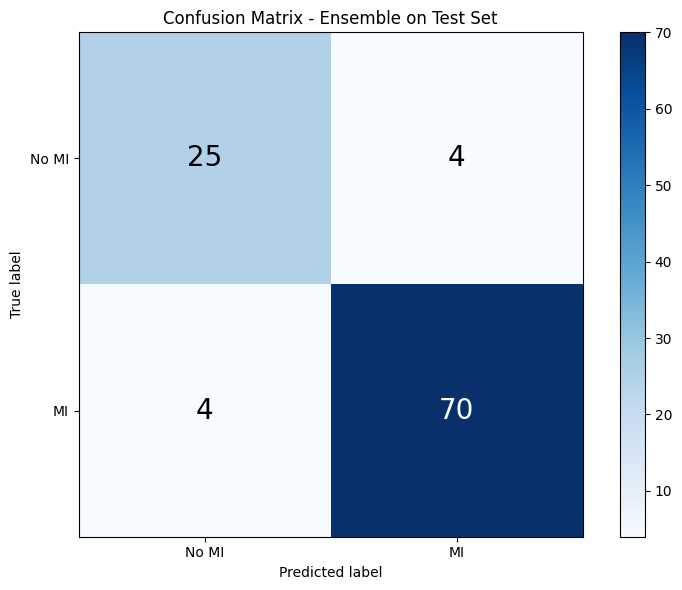


Saving results to CSV...

Results saved to models/cross_validation

Models saved to: models/cross_validation
Total folds trained: 5

Final Ensemble Performance on Test Set:
  Accuracy:  0.9223
  AUC:       0.9623
  F1-Score:  0.9459


In [56]:
results = main()